# Mesh I/O and manipulation

In [1]:
# TODO hide this cell ?

import mitsuba as mi

mi.set_variant("cuda_ad_rgb")

## Read a mesh from disk

Mitsuba provides an abstract `mi.Shape` class to handle all geometric shapes. For triangle meshes, it has a concrete class `mi.Mesh` that is further extended by 3 plugins which can load meshes directly from a file:

- [Wavefront OBJ](): # TODO (link)

- [PLY](): # TODO (link)

- [Serialized](): # TODO (link) 

.#TODO comment about differences of plugins ?

As any other Mitsuba object, we can use the `mi.load_dict` function to instantiate one of these three plugins. They each have their own specific input parameters which you'll find in their respective documentaion, but here are the input parameters they all share:

- **filename**: Filename of the mesh file that should be loaded

- **face_normals**: When set to true, any existing or computed vertex normals are discarded and face normals will instead be used during rendering. This gives the rendered object a faceted appearance.

- **to_world**: Specifies an linear object-to-world transformation. 

In [2]:
bunny = mi.load_dict(
    {
        "type": "ply",
        "filename": "../scenes/meshes/bunny.ply",
        "face_normals": False,
        "to_world": mi.ScalarTransform4f.rotate([0, 0, 1], angle=10),
    }
)

print(bunny) # TODO: Remove print once vcall tracing is fixed

2022-04-13 13:35:31 DEBUG main [PluginManager] Loading plugin "plugins/ply.so" ..

2022-04-13 13:35:31 DEBUG main [PluginManager] Loading plugin "plugins/diffuse.so" ..

2022-04-13 13:35:31 DEBUG main [PluginManager] Loading plugin "plugins/uniform.so" ..

2022-04-13 13:35:31 DEBUG main [PLYMesh] Loading mesh from "bunny.ply" ..

2022-04-13 13:35:31 DEBUG main [PLYMesh] "bunny.ply": read 69451 faces, 208349 vertices (5.56 MiB in 67ms)

PLYMesh[
  name = "bunny.ply",
  bbox = BoundingBox3f[
    min = [-0.0785918, -0.0623055, -0.0730216],
    max = [0.0868213, 0.0980685, 0.0476517]
  ],
  vertex_count = 208349,
  vertices = [4.77 MiB of vertex data],
  face_count = 69451,
  faces = [814 KiB of face data],
  face_normals = 0
]


The string representation of a `mi.Mesh` object gives an overview of its size. If you wish to access some of these values, they are available through the following methods `mi.Shape.bbox`, `mi.Mesh.vertex_count`, `mi.Mesh.face_count`. Direct access to the vertex and face data of the mesh is possible with the `mi.Mesh.face_buffer`, `mi.Mesh.vertex_normals_buffer`, `mi.Mesh.vertex_positions_buffer` and `mi.Mesh.vertex_texcoords_buffer` methods. Each one of the methods also has its individual version which can return data for a single face/vertex by accessing it through its index. Respectively, these methods are: `mi.Mesh.face_indices`, `mi.Mesh.vertex_normal`, `mi.Mesh.vertex_position`, `mi.Mesh.vertex_normal`.

## Procedural mesh 

By directly using the `mi.Mesh` class, it is also possible to procedurally create a mesh. 

To illustrate this, we will build a spanning triangle disk and give it a wavy fringe. The exact details of how the vertex positions and face indices are generated are not important for the purposes of this guide. However, we do leave them as comments in the code.

In [3]:
# Wavy disk construction
#
# Let N define the total number of vertices, the first N-1 vertices will compose
# the fringe of the disk, while the last vertex should be placed at the center.
# The first N-1 vertices must have their height modified such that they oscillate
# with some given frequency and amplitude. To compute the face indices, we define
# the first vertex of every face to be the vertex at the center (idx=N-1) and the
# other two can be assigned sequentially (modulo N-2).

import drjit as dr

# Disk with a wavy fringe parameters
N = 100
frequency = 12.0
amplitude = 0.4

# Generate the vertex positions
theta = dr.linspace(mi.Float, 0.0, dr.TwoPi, N)
x, y = dr.sincos(theta)
z = amplitude * dr.sin(theta * frequency)
vertex_pos = mi.Point3f(x, y, z)

# Move the last vertex to the center
vertex_pos[dr.eq(dr.arange(mi.UInt32, N), N - 1)] = 0.0

# Generate the face indices
idx = dr.arange(mi.UInt32, N - 1)
face_indices = mi.Vector3u(N - 1, (idx + 1) % (N - 2), idx % (N - 2))

The `mi.Mesh` constructor allocates all the necessary buffers to hold its data. Specifically, the constructor takes as arguments the number of vertices and faces which will then be fixed. It is not possible to edit a mesh in a way that would require the buffers to be resized (more/less faces for examples), a new `mi.Mesh` would need to be created for such use cases.
The constructor can also takes two boolean arguments `has_vertex_normals` and `has_vertex_texcoords` that must also be know at the construction of the object, in order to allocate the appropriate buffers.

In [4]:
# Create an empty mesh (allocates buffers of the correct size)
mesh = mi.Mesh(
    "wavydisk",
    vertex_count=N,
    face_count=N - 1,
    has_vertex_normals=False,
    has_vertex_texcoords=False,
)

There are two different ways in which we can assign our existing vertex positions and face indices to the newly created `mi.Mesh` object.

The first option makes use of the provided `_buffer` suffixed methods of `mi.Mesh`, such as `mi.Mesh.vertex_positions_buffer` to directly assign new values. Some changes might require the mesh's bounding box to be updated, or the vertex normals to be recomputed. The two methods `mi.Mesh.recompute_bbox` and `mi.Mesh.recompute_vertex_normals` do exactly that, it is up to the caller to decide whether or not it is necessary to use them.

In [5]:
vertex_pos_buffer = mesh.vertex_positions_buffer()
dr.scatter(
    vertex_pos_buffer,
    dr.ravel(vertex_pos),  # Flat continuous arrays are expected for the buffers
    dr.arange(mi.UInt, 3 * N),
)

face_indices_buffer = mesh.faces_buffer()
dr.scatter(
    face_indices_buffer,
    dr.ravel(face_indices),  # Flat continuous arrays are expected for the buffers
    dr.arange(mi.UInt, 3 * (N - 1)),
)

mesh.recompute_bbox()

The second option use the `mi.traverse` mechanism. All of the allocated buffers of a `mi.Mesh` object are exposed, and can therefore be modified with this mechanism. This approach has the advantage of simplifying some of the assignment operations. In addition, if any vertex position is modified, a call to `mi.SceneParameters.update` will trigger both the bounding box and vertex normals recomputations. 

In [6]:
mesh_params = mi.traverse(mesh)
# Flat continuous arrays are expected for the buffers
mesh_params["vertex_positions"] = dr.ravel(vertex_pos)
mesh_params["faces"] = dr.ravel(face_indices)
mesh_params.update()

Let's take a look at our new mesh!

2022-04-13 13:35:31 DEBUG main [PluginManager] Loading plugin "plugins/path.so" ..

2022-04-13 13:35:32 DEBUG main [PluginManager] Loading plugin "plugins/constant.so" ..

2022-04-13 13:35:32 DEBUG main [PluginManager] Loading plugin "plugins/perspective.so" ..

2022-04-13 13:35:32 DEBUG main [PluginManager] Loading plugin "plugins/hdrfilm.so" ..

2022-04-13 13:35:32 DEBUG main [PluginManager] Loading plugin "plugins/gaussian.so" ..

2022-04-13 13:35:32 DEBUG main [PluginManager] Loading plugin "plugins/independent.so" ..

2022-04-13 13:35:32 INFO main [Scene] Building scene in OptiX ..

2022-04-13 13:35:32 DEBUG main [scene_optix.inl:67] Initialize Optix configuration (index=2)..

2022-04-13 13:35:32 INFO main [Scene] OptiX ready. (took 50ms)

2022-04-13 13:35:32 INFO main [SamplingIntegrator] Starting render job (768x576, 4 samples)

2022-04-13 13:35:32 INFO main [SamplingIntegrator] Computation graph recorded. (took 16ms)

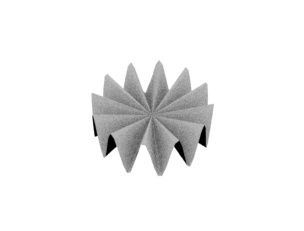

In [7]:
scene = mi.load_dict(
    {
        "type": "scene",
        "integrator": {"type": "path"},
        "light": {"type": "constant"},
        "sensor": {
            "type": "perspective",
            "to_world": mi.ScalarTransform4f.look_at(
                origin=[0, -5, 5], target=[0, 0, 0], up=[0, 0, 1]
            ),
        },
        "wavydisk": mesh,
    }
)

bitmap = mi.Bitmap(mi.render(scene))
bitmap = bitmap.convert(
    mi.Bitmap.PixelFormat.RGB, mi.Struct.Type.UInt8, srgb_gamma=True
)

from matplotlib import pyplot as plt

plt.axis("off")
plt.imshow(bitmap)

## Save a mesh to disk

No matter how a `mi.Mesh` object was loaded or built, it can always be exported to a [PLY file format](https://en.wikipedia.org/wiki/PLY_(file_format)) using the `mi.Mesh.write_ply` method. There are currently no other file formats which are supported.

Any mesh attribute that is attached to the object at the time when `mi.Mesh.write_ply` is called will be written to output file as a property. Mitsuba therefore allows you to create complex procedural properties for your meshes and export them to be used in some other context entirely.

In [8]:
mesh.write_ply("wavydisk.ply")

2022-04-13 13:35:33 INFO main [Mesh] Writing mesh to "wavydisk.ply" ..

2022-04-13 13:35:33 INFO main [Mesh] "wavydisk.ply": wrote 99 faces, 100 vertices (2.33 KiB in 0ms)

In [9]:
# TODO: Delete this cell once raised exceptions in vcall tracing is properly handled
import gc

del mesh
del face_indices_buffer
del vertex_pos_buffer
del mesh_params
del scene
del bunny

gc.collect()
gc.collect()

2022-04-13 13:35:33 DEBUG main [Scene] Free OptiX scene state..

0

## Add and edit attributes

. # TODO (decide whether to use "property" or "attributes" in title -- property seems to be the convention)

Meshes in Mitsuba can have additional properties/attributes per face or per vertex. Each attribute is either one or several floating point numbers, no other types are supported.

The `mi.Mesh.add_attribute` methods let's you define new attributes by giving them a name, a number of floats, and their initial values. The attribute name must be prefixed with either `vertex_` or `face_`, as this defines whether the attribute is defined for each face or for each vertex. For this example, we will be adding a RGB color to each vertex. Mitsuba 3 has a [mesh attribute]() # TODO: link texture plugin that conviently allows you to visualize attributes.

In [10]:
mesh = mi.load_dict(
    {
        "type": "ply",
        "filename": "wavydisk.ply",
        "bsdf": {
            "type": "diffuse",
            "reflectance": {
                "type": "mesh_attribute",
                "name": "vertex_color",  # This will be used to visualize our attribute
            },
        },
    }
)

# Needs to start with vertex_ or face_
attribute_size = mesh.vertex_count() * 3
mesh.add_attribute(
    "vertex_color", 3, [0] * attribute_size
)  # Add 3 floats per vertex (initialized at 0)

2022-04-13 13:35:33 DEBUG main [PluginManager] Loading plugin "plugins/mesh_attribute.so" ..

2022-04-13 13:35:33 DEBUG main [PLYMesh] Loading mesh from "wavydisk.ply" ..

2022-04-13 13:35:33 DEBUG main [PLYMesh] "wavydisk.ply": read 99 faces, 100 vertices (3.5 KiB in 0ms)

2022-04-13 13:35:33 DEBUG main [PLYMesh] "wavydisk.ply": computed vertex normals (took 1ms)

Once an attribute is created it can still be modified. Similarly to what is done in the section [Procedural mesh](), there are two options to edit an existing attribute.

- **`mi.Mesh.attrbute_buffer`**: This method will return the buffer associated to the specified attribute. New values can then be assigned to it with `dr.scatter`.
- **`mi.traverse`**: The attribute's buffer will be exposed with a key corresponding to the attribute's name.

In [11]:
mesh_params = mi.traverse(mesh)
mesh_params

SceneParameters[
  ----------------------------------------------------------------------------------------
  Name                                 Flags    Type            Parent
  ----------------------------------------------------------------------------------------
  bsdf.reflectance.scale                        float           MeshAttribute
  vertex_count                                  int             PLYMesh
  face_count                                    int             PLYMesh
  faces                                         UInt            PLYMesh
  vertex_positions                     ∂, D     Float           PLYMesh
  vertex_normals                       ∂, D     Float           PLYMesh
  vertex_texcoords                     ∂        Float           PLYMesh
  vertex_color                         ∂        Float           PLYMesh
]

In [12]:
N = mesh.vertex_count()

vertex_colors = dr.zero(mi.Float, 3 * N)
fringe_vertex_indices = dr.arange(mi.UInt, N - 1)
dr.scatter(vertex_colors, 1, fringe_vertex_indices * 3)  # Fringe is red
dr.scatter(vertex_colors, 1, [(N - 1) * 3 + 2])  # Center is blue

mesh_params["vertex_color"] = vertex_colors
mesh_params.update()

We can now visualize this attribute.

2022-04-13 13:35:33 INFO main [Scene] Building scene in OptiX ..

2022-04-13 13:35:33 INFO main [Scene] OptiX ready. (took 0ms)

2022-04-13 13:35:33 INFO main [SamplingIntegrator] Starting render job (768x576, 4 samples)

2022-04-13 13:35:33 INFO main [SamplingIntegrator] Computation graph recorded. (took 14ms)

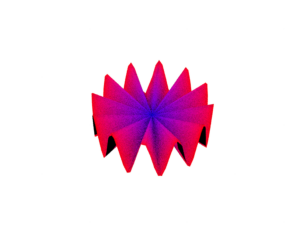

In [13]:
scene = mi.load_dict(
    {
        "type": "scene",
        "integrator": {"type": "path"},
        "light": {"type": "constant"},
        "sensor": {
            "type": "perspective",
            "to_world": mi.ScalarTransform4f.look_at(
                origin=[0, -5, 5], target=[0, 0, 0], up=[0, 0, 1]
            ),
        },
        "wavydisk": mesh,
    }
)

bitmap = mi.Bitmap(mi.render(scene))
bitmap = bitmap.convert(
    mi.Bitmap.PixelFormat.RGB, mi.Struct.Type.UInt8, srgb_gamma=True
)

from matplotlib import pyplot as plt

plt.axis("off")
plt.imshow(bitmap)